# Importando bibliotecas

In [ ]:
!pip install -U -q PyDrive

In [ ]:
# Importando as bibliotecas necessárias para o bom funcionamento do código
import pandas as pd
import numpy as np
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

# Opção 1 - Safra Artificial

A primeira opção para a qual foram aplicados os modelos preditivos desenvolvidos se refere aos registros de uma safra artificial. Desse modo, foram selecionados todos os registros contidos no dataframe, de modo que as proporções relacionadas a determinadas features fossem devidamente balanceadas.

# Carregando dados

In [ ]:
# Autenticação para acesso aos dados
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Download dos dados para esta máquina virtual
downloaded = drive.CreateFile({'id': '1DUV-TOm5NhiaDfBgewwh26Ky7jgoC1mU'})
downloaded.GetContentFile('data.csv')

In [ ]:
# Carregando os dados baixados no dataframe 
df = pd.read_csv('data.csv')
df.head()

,anomes,num_cpf_hash,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
0,202104,fffff8b0db8eff291be8b83f8885f52c52782bb42c3c4b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,202104,ffffd54b45ec46113523184fc07185a0d5cbfa876a07ba...,35943.74,5815.5,NaN,377.0,1.0,NaN,24.0,NaN,10.0,NaN,A,NaN,1.0,NaN
2,202104,ffffd47a92b3e4291c013033ae528708a19eaede50f78e...,6288.22,NaN,NaN,257.0,NaN,NaN,22.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN
3,202104,ffffc102ddd37ec29e985a4564e85a2bace79a85ebff5e...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
4,202104,ffffbd4a3d42a12e07b1202d68c33d43220c42c8a55160...,1238.93,1400.0,NaN,773.0,2.0,NaN,21.0,NaN,NaN,NaN,A,NaN,1.0,NaN


# Análise exploratória dos dados

In [ ]:
import plotly.express as px

* A seguir, estamos calculando algumas médias que podem ser relevantes para o posterior treinamento do nosso modelo preditivo.


In [ ]:
#Calculando Médias

medias = df[['vlr_credito', 'vlr_saldo', 'vlr_score', 'num_atend_atrs', 'num_produtos']].sum()/len(df)
print(medias)
medias.dtypes

medias = pd.DataFrame(medias)

fig = px.bar(medias, y=medias[0], height=400, width=600)
fig.update_xaxes(type='category')
fig.show()

vlr_credito       17473.173800
vlr_saldo          3020.682365
vlr_score           329.011591
num_atend_atrs        0.000579
num_produtos          0.837787
dtype: float64


* Aqui, estamos comparando a quantidade de atendimentos existentes com a quantidade de atendimentos que se encontram atrasados.


In [ ]:
# Média de atendimentos e atendimentos atrasados:
atends = df[['num_atend', 'num_atend_atrs']].sum()/len(df)
df_atends = pd.DataFrame(atends)

# geração de um gráfico com as médias obtidas anteriormente
fig = px.bar(df_atends, y=df_atends[0], height=400, width=600)
fig.update_xaxes(type='category')
fig.show()

In [ ]:
# descrição da quantidade de reclamações
num_reclm = df['qtd_reclm'].describe()
# criação de um data frame com os números encontrados anteriormente.
num_reclm_1 = pd.DataFrame(num_reclm)
# retirada do parâmtro count desse df (data frame) criado
num_reclm_1 = num_reclm_1.drop('count')

# criação de um gráfico para a melhor visualização desses valores
figReclm = px.bar(num_reclm_1, y=num_reclm_1['qtd_reclm'], height=400, width=600)
figReclm.update_xaxes(type='category')
figReclm.show()

In [ ]:
#Análise de clientes que buscam novos produtos/atritados

#NAN das colunas vlr_credito, vlr_saldo e num_produtos sendo trocados por 0;
data= df[['vlr_credito', 'vlr_saldo', 'num_produtos']].replace(np.nan, 0)

#Gera-se um novo dataframe com as informações específicas
data = pd.DataFrame(data);

#Pega-se as pessoas que possuem um saldo bem maior do que o crédito e que possuem produtos no banco.
data[(data.vlr_credito < 1500) & (data.vlr_saldo > data.vlr_credito) & (data.vlr_saldo > 10000) & (data.num_produtos >= 1) & (data.vlr_credito > 0)]

,vlr_credito,vlr_saldo,num_produtos
3489,510.14,26435.15,1.0
14019,934.38,11399.38,2.0
15217,837.90,10650.00,1.0
17704,632.76,11749.76,1.0
19145,533.44,10033.61,1.0
...,...,...,...
12024943,326.18,28859.89,2.0
12026111,559.22,12199.66,1.0
12030064,1197.92,22816.94,1.0
12031855,1172.41,20147.12,1.0


In [ ]:
#Análise de cliente a partir do score e do cod_rating

#NAN das colunas cod_rating, vlr_score e num_produtos sendo trocados por 0;
data_score = df[['cod_rating', 'vlr_score', 'num_produtos']].replace(np.nan, 0);

#Gera-se um novo dataframe com as informações específicas
data_score = pd.DataFrame(data_score);

#Selecionando pessoas que têm produtos, possuem score maior do que 400, e que não estejam com rating E, F ou G
print("Quantidade de pessoas com métricas normais: ")
print(len(data_score[(data_score.vlr_score > 400) & (data_score.vlr_score != 0) & ((data_score.cod_rating != 'E') | (data_score.cod_rating != 'F') | (data_score.cod_rating != 'G') | (data_score.cod_rating != 0)) & (data_score.num_produtos >= 1)]))

#Selecionando pessoas que têm produtos, possuem score menor do que 400, e que estejam com rating E, F ou G
print("Quantidade de pessoas com métricas anormais: ")
len(data_score[(data_score.vlr_score < 400) & (data_score.vlr_score != 0) & ((data_score.cod_rating == 'E') | (data_score.cod_rating == 'F') | (data_score.cod_rating == 'G')) & (data_score.num_produtos >= 1)])

Quantidade de pessoas com métricas normais: 
3916779
Quantidade de pessoas com métricas anormais: 


122278

In [ ]:
#NAN das colunas num_atend, num_atend_atrs sendo trocados por 0;
data = df[['num_atend', 'num_atend_atrs']].replace(np.nan, 0);

#Gera-se um novo dataframe com as informações específicas
data = pd.DataFrame(data)

#Pega-se a quantidade de atendimentos que foram feitos e estão em dia.
length_nao_atrs = len(data[(data.num_atend > 0) & (data.num_atend_atrs == 0)])

print('Quantidade de atendimentos que foram feitos mas não estão em atraso: ', length_nao_atrs)

#Pega-se a quantidade de atendimentos que foram feitos e não estão em dia.
length_atrs = len(data[(data.num_atend > 0) & (data.num_atend_atrs > 0)])

print('========================================================================')

print('Quantidade de atendimentos que foram feitos e estão em atraso: ', length_atrs)

Quantidade de atendimentos que foram feitos mas não estão em atraso:  18441
Quantidade de atendimentos que foram feitos e estão em atraso:  6224


In [ ]:
df

,anomes,num_cpf_hash,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
0,202104,fffff8b0db8eff291be8b83f8885f52c52782bb42c3c4b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,202104,ffffd54b45ec46113523184fc07185a0d5cbfa876a07ba...,35943.74,5815.50,NaN,377.0,1.0,NaN,24.0,NaN,10.0,NaN,A,NaN,1.0,NaN
2,202104,ffffd47a92b3e4291c013033ae528708a19eaede50f78e...,6288.22,NaN,NaN,257.0,NaN,NaN,22.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN
3,202104,ffffc102ddd37ec29e985a4564e85a2bace79a85ebff5e...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
4,202104,ffffbd4a3d42a12e07b1202d68c33d43220c42c8a55160...,1238.93,1400.00,NaN,773.0,2.0,NaN,21.0,NaN,NaN,NaN,A,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12032488,202204,000055dd71d2394bf27d4fb46f4e8a91ba90a604774953...,970.18,NaN,NaN,415.0,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12032489,202204,00003a6cf049e4fe3416c1a55d1fc1aac613956ecd5d7a...,0.00,NaN,NaN,689.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12032490,202204,000038baed6e8076adec7272523211faaec7bf8b30b1e1...,30268.92,1631.88,NaN,359.0,1.0,NaN,17.0,NaN,6.0,NaN,A,NaN,1.0,NaN
12032491,202204,00003671431c71ae1a84ec138b63c7a6e465f9616af5ea...,NaN,NaN,NaN,373.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,1.0


# **Limpeza dos dados - parte 1**

* Em primeiro lugar, é necessário retirar as linhas que não possuem cod_rating (parâmetro utilizado internamente pelo banco para classificar seus clientes), a fim de facilitar o aprendizado do nosso modelo preditivo, visto que, se não há registro de cod_rating, necessariamente a linha não pertence a um cliente do banco.

* Após a resolução desse primeiro empecilho, trocamos todos os valores nulos das colunas "num_atend", "num_atend_atrs", "qtd_reclm", "qtd_restr", "ind_atrito", "ind_engaj", "ind_novo_client" e "vlr_score" para o valor zero (0), porque o modelo preditivo não consegue identificar e nem manipular dados diferentes de números.

* Finalizando essa primeira parte, mudamos os parâmetros do cod_rating de letras (A, B, C, D, E, F, G, H e HH) para números (0, 1, 2, 3, 4, 5, 6, 7 e 8, respectivamente)

In [ ]:
print(len(df))
df = df[~df.cod_rating.isnull()]
print(len(df))
df[['num_atend', 'num_atend_atrs', 'qtd_reclm', 'qtd_restr', 'ind_atrito', 'ind_engaj', 'ind_novo_cli', 'vlr_score', 'num_produtos']] = df[['num_atend','num_atend_atrs','qtd_reclm', 'qtd_restr', 'ind_atrito', 'ind_engaj', 'ind_novo_cli', 'vlr_score', 'num_produtos']].fillna(0)

le = LabelEncoder()
df['cod_rating'] = le.fit_transform(df['cod_rating'])

df

6186773
6186773


,anomes,num_cpf_hash,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
1,202104,ffffd54b45ec46113523184fc07185a0d5cbfa876a07ba...,35943.74,5815.50,0.0,377.0,1.0,0.0,24.0,0.0,10.0,NaN,0,0.0,1.0,0.0
4,202104,ffffbd4a3d42a12e07b1202d68c33d43220c42c8a55160...,1238.93,1400.00,0.0,773.0,2.0,0.0,21.0,0.0,0.0,NaN,0,0.0,1.0,0.0
7,202104,ffff6070251f9e50f54190b914ed6fd735e11064d661ab...,12607.75,31.70,0.0,0.0,0.0,0.0,9.0,0.0,0.0,NaN,9,0.0,0.0,0.0
8,202104,ffff4ef886c28af8029c6b7d504942e6c9ef13021e9a35...,81506.54,5243.45,0.0,560.0,1.0,0.0,14.0,0.0,0.0,NaN,0,0.0,0.0,0.0
9,202104,ffff4bbb4074d7894174fd94c685edb3fd7fc9b7b1e3c1...,112918.62,7252.64,0.0,374.0,2.0,0.0,23.0,0.0,0.0,NaN,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12032484,202204,00008503efab22c4b17633da58b19557d135887e01db0e...,36333.58,5942.14,0.0,538.0,4.0,0.0,40.0,0.0,1.0,NaN,2,0.0,1.0,0.0
12032485,202204,00008166c6d8213d5372a4a6336322f14e7f15b982cf5d...,43054.69,2620.89,0.0,437.0,2.0,0.0,17.0,0.0,8.0,NaN,0,0.0,0.0,0.0
12032486,202204,00006b833ab2b4c8220f61fdd90c5833040030ff1b015e...,NaN,11239.24,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,9,0.0,0.0,0.0
12032487,202204,0000567d0d7f3813befdc85b65838d685ec6d89bb067bd...,21959.05,4017.00,0.0,410.0,1.0,0.0,15.0,0.0,4.0,NaN,8,0.0,0.0,0.0


## Seleção de dados
 
**Após a de limpeza dos dados ausentes e dos dados nulos, definimos quais as features que serão utilizadas na construção do modelo preditivo. Para fazer tal escolha, consideramos os atributos da base de dados do cliente que são relevantes no processo de análise da conduta de um cliente do Banco PAN.**
 
• Safra (“anomes”) --> Ao analisar a safra (ano e mês), conseguimos observar o comportamento do cliente ao longo do tempo e estimar seu comportamento futuro enquanto cliente do banco.
 
• Valor de crédito (“vlr_credito”) --> O valor de crédito no mercado avalia a situação do cliente no mercado ao declarar seu valor total de crédito,sendo indicador de possíveis atritos entre cliente e banco, bem como indicações de novos clientes ou clientes que possam ter a intenção de adquirir novos produtos.
 
• Valor de saldo (“vlr_saldo”) --> O valor total de saldo do cliente indica se há atrito na relação que será predita pelo modelo artificial. 
    
• Número de atendimentos (“num_atend” e “num_atend_atrs”) --> O número total de atendimentos e número de atendimentos atrasados é um dos principais indicativos de atrito de um cliente com o Banco Pan.
    
• Valor do score (“vlr_score”)  --> O valor do score no Serasa de um cliente é capaz de identificar a necessidade do cliente de adquirir, por exemplo, certo valor de crédito no banco.
 
• Número de produtos (“num_produtos”) --> Quanto maior o número de serviços aderidos, menor pode ser o nível de atrito com a instituição, considerando a preferência pelo Banco PAN quanto a esses serviços.
 
• Quantidade de operações (“qtd_oper”) --> Quando um cliente possui muitas operações referentes a um mesmo serviço, deve ser considerada a preferência pelo Banco PAN frente a outras instituições financeiras.
 
• Quantidade de reclamações (“qtd_reclm”) --> Se um cliente possui muitas reclamações, ele se sente insatisfeito com os serviços oferecidos pelo Banco PAN.
 
• Quantidade de restritivos no mercado (“qtd_restr”) --> Considera as restrições financeiras do cliente em outras instituições financeiras.

• Rating do cliente (“cod_rating”) --> Refere-se ao risco que o cliente representa para o banco, indicando se existem atritos nessa relação ou se é provável que o cliente adquira novos produtos na instituição.
 
• Índice de atrito (“ind_atritado”) --> É uma métrica interna do banco que quantifica possíveis conflitos entre o Banco PAN e seus clientes. Se esse índice for alto, pode indicar que o cliente está ligando para efetuar uma reclamação.
 
• Índice de engajamento (“ind_engajado”) --> Reflete o quão engajado o cliente é com a instituição, auxiliando o modelo preditivo a analisar se é alta ou baixa a probabilidade de que o cliente contate o banco para adquirir novos produtos ou serviços.
 
• Índice de identificação de novo cliente (“ind_novo_cliente”) --> Identifica potenciais clientes do Banco PAN, os quais serão identificados ao entrarem em contato com o atendimento da instituição, de modo que a intenção de abrir uma conta no banco seja predita pelo modelo preditivo.
 
**Por fim, foram definidos os campos que não serão utilizados na construção da lógica do modelo preditivo, os quais encontram-se dispostos abaixo.**
 
• Número do CPF (“num_cpf”) --> Os clientes não serão avaliados individualmente, o modelo preditivo irá considerar um conjunto de clientes. Além disso, os clientes devem ser mantidos anônimos e os valores deste campo são strings, não sendo reconhecidos pelo modelo. 
 
• Valor da renda (“vlr_renda") --> A maioria dos valores para esse campo são nulos (NaN), não havendo uma quantidade suficiente de registros para que o atributo em questão influencie as predições realizadas.

In [ ]:
# importando as bibliotecas que serão utilizadas 
import plotly.express as px
import random

In [ ]:
#  # geração de um número aleatório referente à safra
# random_number = random.randint(1,12)
# # eliminação de safras duplicadas, restando apenas 12 safras, referentes aos meses do ano
# safra_unica= df.drop_duplicates('anomes')
# # escolha de uma safra aleatória entre as 12 existentes
# safra_escolhida = safra_unica['anomes'].iloc[12]
# print(safra_escolhida)
# # seleção dos cpfs que se enquadram na safra escolhida, existindo um cpf por linha, apenas
# todos_cpfs_safra = df[df['anomes'] == safra_escolhida]

In [ ]:
# # Atribuição, ao data frame antigo, do novo data frame com cpf's únicos 
# df = todos_cpfs_safra

# **Limpeza dos dados - parte 2**

* Nessa etapa, retiramos aquelas linhas (que representam pessoas) que possuem valor de crédito e saldo como **nulos** devido ao fato de que há uma alta probabilidade de que essas possoas não possuam conta no Banco Pan. 

* Posteriormente, a partir de uma verificação, percebemos que existem linhas que, apesar de possuirem valores concretos de score, valor de saldo, crédito, número de atendimentos, etc. não possuem informações na coluna **renda**. Dessa forma, a fim de potencializar o funcionamento do modelo preditivo nós, após perceber a irrelevância dessa coluna para a construção desse, decidimos retirá-la da tabela. Além dela, retiramos, também, a coluna que continha o cpf, visto que, por ter sofrido um processo de hash, possuia letras em sua composição e não era compreendido pela predição. 



In [ ]:
# retirada de todos os valores de crédito e saldo que estão nulos
df = df[~df.vlr_credito.isnull() & ~df.vlr_saldo.isnull()]
# exclusão das colunas renda e cpf
df = df.drop('vlr_renda', axis=1)
df = df.drop('num_cpf_hash', axis=1)
# verificação das mudanças realizadas:
df

,anomes,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
1,202104,35943.74,5815.50,0.0,377.0,1.0,0.0,24.0,0.0,10.0,0,0.0,1.0,0.0
4,202104,1238.93,1400.00,0.0,773.0,2.0,0.0,21.0,0.0,0.0,0,0.0,1.0,0.0
7,202104,12607.75,31.70,0.0,0.0,0.0,0.0,9.0,0.0,0.0,9,0.0,0.0,0.0
8,202104,81506.54,5243.45,0.0,560.0,1.0,0.0,14.0,0.0,0.0,0,0.0,0.0,0.0
9,202104,112918.62,7252.64,0.0,374.0,2.0,0.0,23.0,0.0,0.0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12032483,202204,1171.12,690.80,0.0,575.0,4.0,0.0,9.0,0.0,0.0,0,0.0,1.0,0.0
12032484,202204,36333.58,5942.14,0.0,538.0,4.0,0.0,40.0,0.0,1.0,2,0.0,1.0,0.0
12032485,202204,43054.69,2620.89,0.0,437.0,2.0,0.0,17.0,0.0,8.0,0,0.0,0.0,0.0
12032487,202204,21959.05,4017.00,0.0,410.0,1.0,0.0,15.0,0.0,4.0,8,0.0,0.0,0.0


Gero um BackUp, caso o DF seja substituido sem querer por algo errado não há a necessidade de reler o CSV

In [ ]:
#Backup

backup = df

In [ ]:
df=backup
df

,anomes,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
1,202104,35943.74,5815.50,0.0,377.0,1.0,0.0,24.0,0.0,10.0,0,0.0,1.0,0.0
4,202104,1238.93,1400.00,0.0,773.0,2.0,0.0,21.0,0.0,0.0,0,0.0,1.0,0.0
7,202104,12607.75,31.70,0.0,0.0,0.0,0.0,9.0,0.0,0.0,9,0.0,0.0,0.0
8,202104,81506.54,5243.45,0.0,560.0,1.0,0.0,14.0,0.0,0.0,0,0.0,0.0,0.0
9,202104,112918.62,7252.64,0.0,374.0,2.0,0.0,23.0,0.0,0.0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12032483,202204,1171.12,690.80,0.0,575.0,4.0,0.0,9.0,0.0,0.0,0,0.0,1.0,0.0
12032484,202204,36333.58,5942.14,0.0,538.0,4.0,0.0,40.0,0.0,1.0,2,0.0,1.0,0.0
12032485,202204,43054.69,2620.89,0.0,437.0,2.0,0.0,17.0,0.0,8.0,0,0.0,0.0,0.0
12032487,202204,21959.05,4017.00,0.0,410.0,1.0,0.0,15.0,0.0,4.0,8,0.0,0.0,0.0


# **Tratamento de dados - parte 1** 

Aqui nós fazemos pegamos a nossa base de dados, já anteriormente limpada, e então criamos uma proporção entre atritados e não atritados, pelo fato de que na Base de dados passada para nós a quantidade de pessoas não atritadas é imensamente maior do que a quantidade de pessoas atritadas.

In [ ]:
#Defino um novo DataFrame somente com os clientes atritados 
new_teste = df[(df.ind_atrito == 1)]
length_n_atrito = len(new_teste)

#Multiplico o tamanho do DataFrame de clientes atritados por 1.4 para balancear a quantidade de atritados e não atitados
length_to_balence = int(length_n_atrito * 1.4) #1.4: valor definido manualmente por testes

#Pego um novo DataFrame somente com clientes não atritados, pegando somente a quantidade anteriormente definida
new_nao_atrito = df[(df.ind_atrito == 0)].head(length_to_balence)
length_atrito = len(new_nao_atrito)

#Concateno os dataframes de não atritados e atritados, ficando assim balanceado e não enviesando o modelo
frames = [new_teste, new_nao_atrito]
df = pd.concat(frames)
df = df.sample(frac=1)
df

,anomes,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
2016,202104,12592.26,12122.13,0.0,641.0,3.0,0.0,7.0,0.0,0.0,0,0.0,0.0,0.0
6036,202104,34975.54,2712.74,0.0,323.0,1.0,0.0,22.0,0.0,2.0,0,0.0,1.0,0.0
1390274,202105,20690.65,1520.71,0.0,611.0,2.0,1.0,15.0,1.0,0.0,0,1.0,1.0,0.0
409826,202104,3475.19,1752.43,0.0,0.0,1.0,0.0,9.0,1.0,0.0,0,1.0,1.0,0.0
5137,202104,12199.93,1765.28,0.0,479.0,3.0,0.0,19.0,0.0,0.0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3440,202104,2977.86,560.00,0.0,693.0,1.0,0.0,7.0,0.0,0.0,0,0.0,0.0,0.0
6356,202104,177238.34,1020.00,0.0,833.0,1.0,0.0,21.0,0.0,0.0,0,0.0,0.0,0.0
2968,202104,36286.20,983.74,0.0,0.0,1.0,0.0,13.0,0.0,1.0,0,0.0,0.0,0.0
7433,202104,34068.48,878.13,0.0,0.0,1.0,0.0,31.0,0.0,2.0,0,0.0,0.0,0.0


#**Tratamento de dados - parte 2**

Verificação das melhores váriaveis que o DF possui para o modelo.

In [ ]:
# model = LogisticRegression(max_iter=2000)

# x = df.drop(columns = ['ind_atrito', 'ind_engaj', 'ind_novo_cli']).values
# y = df[['ind_atrito']].values

# rfe = RFE(model, n_features_to_select=9)

# fit = rfe.fit(x, y)

# print("Número de features: {}".format(fit.n_features_))

# cols = fit.get_support(indices=True)
# best_cols = df.iloc[:, cols]
# df[best_cols.columns]

#Verifica as melhores váriaveis do DF, não sei se vamos usar

* Agora, com os nulos tratados, queremos conferir se existe algum dado no data frame que permaneça nulo, a fim de corrirgir caso o resultado seja diferente de zero. 

In [ ]:
# conferindo a existência de dados nulos
df.isnull().sum()

anomes            0
vlr_credito       0
vlr_saldo         0
num_atend_atrs    0
vlr_score         0
num_produtos      0
num_atend         0
qtd_oper          0
qtd_reclm         0
qtd_restr         0
cod_rating        0
ind_atrito        0
ind_engaj         0
ind_novo_cli      0
dtype: int64

# Normalização e padronização dos dados



A normalização precisa ser feita após a realização da separação de treinamento e teste. Após essa etapa, é preciso realizar a normalização apenas no conjunto de treinamento para que, posteriormente, ela seja aplicada no conjunto de teste. 
Fit: Treinamento
Tranformação: treinamento e teste

### Normalização:


In [ ]:
def drop_outliers(df_to_change, column, percent):
    percentage = int(len(df_to_change) * percent)

    df_to_change = df_to_change.sort_values(column, ascending = True)
    df_to_change = df_to_change.iloc[percentage: ]
    df_to_change = df_to_change.sort_values(column, ascending = False)
    df_to_change = df_to_change.iloc[percentage: ]
    return df_to_change

In [ ]:
teste = df

df = drop_outliers(df, 'vlr_saldo', 0.025)
df = drop_outliers(df, 'vlr_credito', 0.025)
df = drop_outliers(df, 'num_atend_atrs', 0.025)
df = drop_outliers(df, 'num_produtos', 0.025)
df = drop_outliers(df, 'num_atend', 0.025)
df = drop_outliers(df, 'qtd_oper', 0.025)
df = drop_outliers(df, 'qtd_reclm', 0.025)
df = drop_outliers(df, 'qtd_restr', 0.025)

df

,anomes,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
11172323,202204,8505.92,500.12,0.0,219.0,2.0,0.0,18.0,0.0,9.0,0,0.0,0.0,0.0
11172365,202204,29267.96,516.95,0.0,130.0,2.0,0.0,43.0,0.0,9.0,1,0.0,0.0,0.0
11172008,202204,123398.53,1342.50,0.0,295.0,1.0,0.0,32.0,0.0,8.0,4,0.0,1.0,0.0
11172361,202204,6180.79,6180.79,0.0,244.0,2.0,0.0,10.0,0.0,8.0,0,0.0,0.0,0.0
11172021,202204,17457.21,17948.21,0.0,443.0,2.0,0.0,6.0,0.0,7.0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11259565,202204,9979.68,10013.00,0.0,659.0,3.0,0.0,10.0,0.0,0.0,0,1.0,0.0,0.0
11172332,202204,10148.13,4512.67,0.0,960.0,1.0,0.0,16.0,0.0,0.0,0,0.0,0.0,0.0
11172012,202204,89356.95,1649.60,0.0,777.0,1.0,0.0,16.0,0.0,0.0,0,0.0,1.0,0.0
11208447,202204,38628.48,16062.57,0.0,412.0,3.0,0.0,12.0,0.0,0.0,0,1.0,1.0,0.0


## Normalização de valores da tabela
Nos campos seguintes é possível visualizar a normalização vetorial dos valores das colunas 'vlr_credito' e 'vlr_saldo'.
Isso se dá pelo fato que são valores de credito e saldo são valores geralmente redundantes, e para melhor processamento e desempenho do sistema, é adotado o processo de normalização, calculando a média e classificando os mesmos pelos seus respectivos desvios padrões.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Criando o objeto que será utilizado para converter os valores
scaler = MinMaxScaler()

# Seleciona os dados a serem normalizados pelo dataframe principal
dados_pendentes = df[['vlr_credito', 'vlr_saldo']]

# Dados formatados ( normalizados ), resgatados do método de transformação do MinMaxScaler
scaler_data = scaler.fit_transform(dados_pendentes)

In [ ]:
# Criamos o dataframe para utilização dos dados normalizados, utilizando como base, as colunas dos dados anteriores a serem formatados.
numeric_df_scaled = pd.DataFrame(scaler_data, columns = dados_pendentes.columns)

numeric_df_scaled.head()

,vlr_credito,vlr_saldo
0,0.051927,0.006777
1,0.183689,0.007269
2,0.781068,0.031385
3,0.037171,0.172727
4,0.108735,0.516490


#**Criação e testagem de diferentes modelos:**

- Importação das bibliotecas de avaliação de modelos

In [ ]:
from sklearn.tree import plot_tree
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

* Abaixo, temos a separação dos dados para o eficiente funcionamento do modelo. Dividimos os dados em dois grupos diferentes: um para o teste do modelo e outro para o seu treinamento. 


### Train-Test Split

Separação das variáveis de treino e teste

In [ ]:
# Dividindo x e y
x = df.drop(columns = ['ind_atrito', 'ind_engaj', 'ind_novo_cli']).values
y = df[['ind_atrito']].values

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.25, 
                                                    random_state = 42)

INÍCIO DOS MODELOS

Métricas usadas para avaliação:

*   Acurácia: Para descobrirmos a proximidade entre o valor obtido experimentalmente e o valor verdadeiro
*   Precisão: Grau de variação gerado por diferentes medições, quanto mais preciso for um processo, menor será a variação entre os valores obtidos
*   Recall: Como queremos o mínimo de falsos negativos possível (modelo falar que não é atritado mas, o cliente estar atritado), usamos a revocação que basicamente vê dentre todas as situações de classe Positivo como valor esperado, quantas estão corretas.
 


### KNN (K-Nearest Neighbor)

In [ ]:
# Treinando o modelo

modelKNN = KNeighborsClassifier(n_neighbors=1)

modelKNN.fit(x_train, y_train)

# Realizando as predições

y_pred = modelKNN.predict(x_test)

# Calculando quanto é a porcentagem de acerto do modelo
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

print("Precisão",metrics.precision_score(y_test, y_pred))

print("Recall:",metrics.recall_score(y_test, y_pred))

Acurácia: 0.5816845675522895
Precisão 0.49411764705882355
Recall: 0.5170998632010944


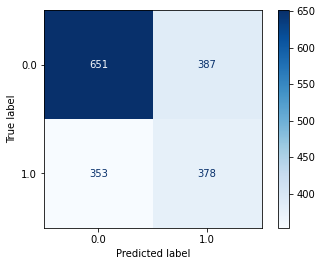

In [ ]:
# Matriz de confusão para o modelo KNN

plot_confusion_matrix(modelKNN, x_test, y_test, cmap='Blues', values_format='.0f')

Analisando o resultado percebemos que este modelo está bem mediano, tendo uma acurácia de aproximadamente 0,60. Portanto, ele foi descartado como modelo principal.

### SVM (Support-Vector Machine)

In [ ]:
# --> TRAIN TEST SPLIT
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Divisão de x e y
x = df.drop(columns =['ind_atrito', 'ind_engaj', 'ind_novo_cli']).values
y = df[['ind_atrito']].values

#Dados para treino e teste
x_train, x_test, y_train, y_test = train_test_split (x,y, test_size = 0.33, random_state = 42)

# --> SUPPORT VECTOR MACHINES
#Importando a biblioteca necessária
from sklearn import svm
from sklearn.svm import SVC

clf = svm.SVC()
modelSvm = clf.fit(x_train, y_train)

In [ ]:
y_pred = clf.predict(x_test)

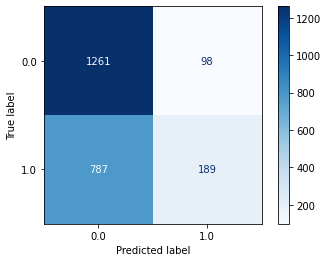

In [ ]:
#MATRIZ DE CONFUSÃO

from sklearn.tree import plot_tree
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(modelSvm, x_test, y_test, cmap='Blues', values_format='.0f')

In [ ]:
#Importando a biblioteca necessária para calcular as métricas
from sklearn import metrics

#Acurácia - Com que frequência o classificador está correto?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#Precisão - Das classificações positivas do modelo, quantas foram acertadas.
print("Precision:",metrics.precision_score(y_test, y_pred))

#Revocação - Das amostras positivas existentes, quantas o modelo conseguiu classificar corretamente.
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.6209850107066381
Precision: 0.6585365853658537
Recall: 0.19364754098360656


Também descartamos a opção do SVM já que, além  de ter tido uma acurácia média (0.54), seu recall e precisão foram de 0.0

### Random Forest

Para o modelo de Random Forest, usei a acurácia como métrica de avaliação. Para atingir o maior número, testei como profundidade máximas da árvore (max_depth) 2, 10, 15, 20, 25, 30, 40 e 50. Antes dos 20, todos ficaram com 0.693, a partir do 20, todos ficaram com uma acurácia de aproximadamente 0.694, por isso, usei como max_depth o valor 20!

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
#declaro o nome do meu modelo, e declaro a profundade máxima em 20, já que entre 1 < 20 a acurácia é menor
# e entre 20> não há um aumento significante para a acurácia (valores testados: 2, 10, 15, 20, 25, 30, 40, 50)
clf = RandomForestClassifier(max_depth=20, random_state=0)
#treino meu modelo
clf.fit(x_train, y_train)
#ele prediz o x teste
y_pred = clf.predict(x_test)
#analiso a acurácia entre o teste e o que ele prediz
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

print("Precisão",metrics.precision_score(y_test, y_pred))

print("Recall:",metrics.recall_score(y_test, y_pred))

Acurácia: 0.9845824411134904
Precisão 0.9978813559322034
Recall: 0.9651639344262295


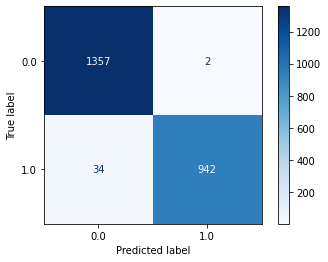

In [ ]:
plot_confusion_matrix(clf, x_test, y_test, cmap='Blues', values_format='.0f')

O modelo do random forest acertou muito bem, tendo uma acurácia de 0.98 e um recall de 0.96, foi uma das melhores performances de modelos, porém por não ser a melhor, descartamos essa opção também.

## Regressão Logística

In [ ]:
# Treinando o modelo
modelLog = LogisticRegression(max_iter=2000).fit(x_train, y_train)

# Fazendo as predições
y_pred = modelLog.predict(x_test)


# Calculando quanto é a porcentagem de acerto do modelo
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

print("Precisão",metrics.precision_score(y_test, y_pred))

print("Recall:",metrics.recall_score(y_test, y_pred))

Acurácia: 0.6201284796573876
Precisão 0.6109725685785536
Recall: 0.2510245901639344


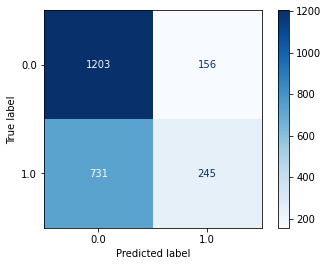

In [ ]:
# Matriz de confusão para o modelo de Regressão Logística

plot_confusion_matrix(modelLog, x_test, y_test, cmap='Blues', values_format='.0f')

Por ter um recall baixo e acurácia e precisão medianos, este também não será o nosso modelo final.

## GaussianNB

In [ ]:
# Treinando o modelo
modelGau = GaussianNB().fit(x_train, y_train)

# Fazendo as predições
y_pred = modelGau.predict(x_test)

# Calculando o erro r2- medida de qualidade do modelo
print("R ao quadrado:",r2_score(y_test, y_pred))

# Calculando quanto é a porcentagem de acerto do modelo
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

print("Precisão",metrics.precision_score(y_test, y_pred))

print("Recall:",metrics.recall_score(y_test, y_pred))

R ao quadrado: 0.061693295455916064
Acurácia: 0.7717344753747324
Precisão 0.914018691588785
Recall: 0.5010245901639344


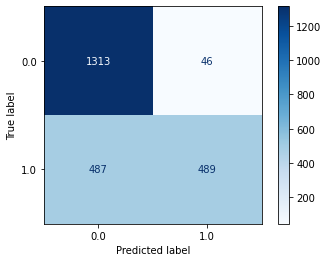

In [ ]:
plot_confusion_matrix(modelGau, x_test, y_test, cmap='Blues', values_format='.0f')

O GaussianNB não serviu como modelo principal pois desempenhou mal em todas as métricas escolhidas (abaixo de 0.6 em todas).

## DecisionTreeClassifier

In [ ]:
# Dividindo x e y
x = df.drop(columns = ['ind_atrito', 'ind_engaj', 'ind_novo_cli']).values
y = df[['ind_atrito']].values

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Treinando o modelo
modelTree = DecisionTreeClassifier(criterion='entropy', random_state=42).fit(x_train, y_train)

#criterion='entropy', random_state=42

# Fazendo as predições
y_pred = modelTree.predict(x_test)

# Calculando o erro r2- medida de qualidade do modelo
print("R ao quadrado:",r2_score(y_test, y_pred))

# Calculando quanto é a porcentagem de acerto do modelo
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))

print("Precisão",metrics.precision_score(y_test, y_pred))

print("Recall:",metrics.recall_score(y_test, y_pred))

R ao quadrado: 0.8685904976535124
Acurácia: 0.9681978798586572
Precisão 0.9542372881355933
Recall: 0.9690189328743546


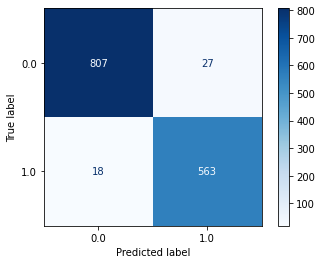

In [ ]:
plot_confusion_matrix(modelTree, x_test, y_test, cmap='Blues', values_format='.0f')

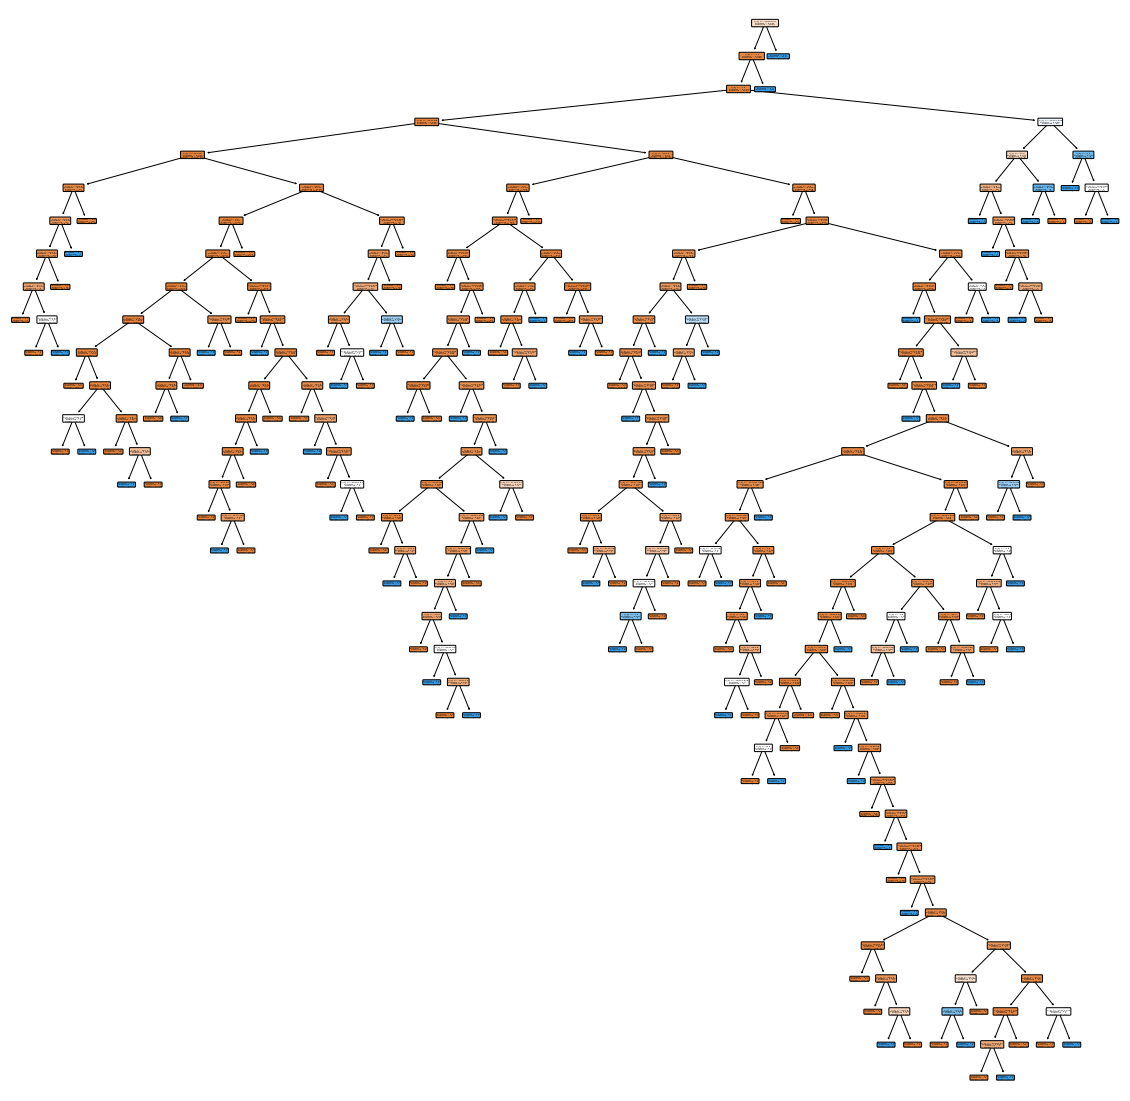

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
_ = plot_tree(modelTree,
            filled=True, rounded=True, ax=ax)
#Gera um arquivo no Notebook, que contém tal imagem com qualidade excelente
plt.savefig('out.pdf')

O modelo de decision tree classifier também foi bastante mediano em acurácia e precisão, porém consideramos ele também um forte candidato pelo bom número de recall.

## Gradient Boosting


--------------------------------------------------------------------
Learning rate:  0.05
Acurácia (treinamento): 0.959
Acurácia (teste): 0.958
Acurácia (final): 0.958
Precisão: 1.000
Recall: 0.897
--------------------------------------------------------------------
Learning rate:  0.075
Acurácia (treinamento): 0.968
Acurácia (teste): 0.970
Acurácia (final): 0.970
Precisão: 1.000
Recall: 0.928
--------------------------------------------------------------------
Learning rate:  0.1
Acurácia (treinamento): 0.968
Acurácia (teste): 0.971
Acurácia (final): 0.971
Precisão: 0.996
Recall: 0.933
--------------------------------------------------------------------
Learning rate:  0.25
Acurácia (treinamento): 0.979
Acurácia (teste): 0.977
Acurácia (final): 0.977
Precisão: 0.996
Recall: 0.948
--------------------------------------------------------------------
Learning rate:  0.5
Acurácia (treinamento): 0.984
Acurácia (teste): 0.982
Acurácia (final): 0.982
Precisão: 0.996
Recall: 0.959
-----------

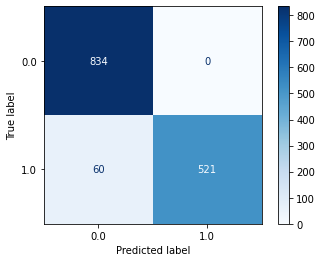

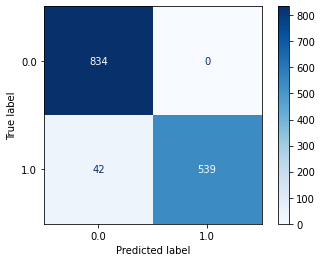

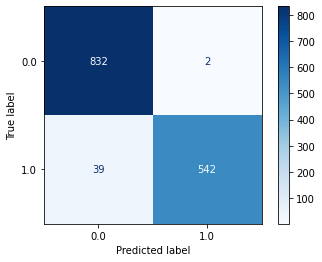

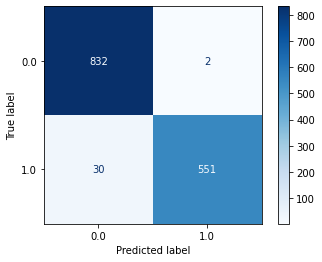

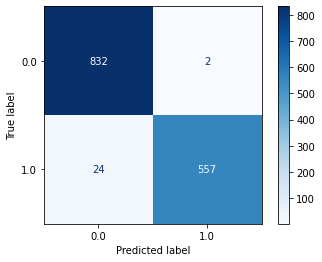

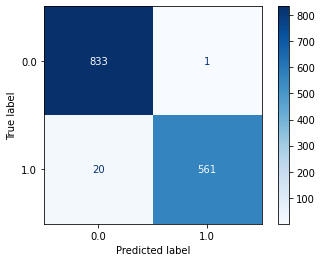

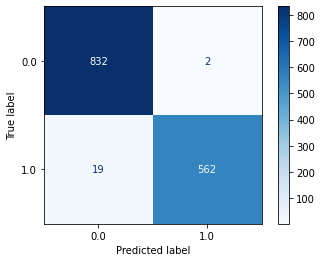

In [ ]:
# Dividindo x e y
x = df.drop(columns = ['ind_atrito', 'ind_engaj', 'ind_novo_cli']).values
y = df[['ind_atrito']].values

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(x_train, y_train)

    # Fazendo as predições
    y_pred = gb_clf.predict(x_test)

    print("--------------------------------------------------------------------")
    print("Learning rate: ", learning_rate)
    print("Acurácia (treinamento): {0:.3f}".format(gb_clf.score(x_train, y_train)))
    print("Acurácia (teste): {0:.3f}".format(gb_clf.score(x_test, y_test)))
    print("Acurácia (final): {0:.3f}".format(metrics.accuracy_score(y_test, y_pred)))
    print("Precisão: {0:.3f}".format(metrics.precision_score(y_test, y_pred)))
    print("Recall: {0:.3f}".format(metrics.recall_score(y_test, y_pred)))
    plot_confusion_matrix(gb_clf, x_test, y_test, cmap='Blues', values_format='.0f')

Por final, nosso modelo escolhido foi o Gradient Boosting, isso se deve por ele ter tido números incríveis de:
* Acurácia: 0.98
* Precisão: 0.99
* Recall: 0.96
Conforme a matriz de confusão mostra, houve muito pouco falsos positivos e falsos negativos.

#**Otimização e padronização dos modelos escolhidos:**

## Estratégia de avaliação escolhida

## Resultados preliminares obtidos

A partir de nossos resultados obtidos a partir da execução de 7 diferentes tipos de modelo para a mesma base de dados, a conclusão obtida pelo grupo foi de que haviam três modelos muito bons que eram o Random Forest, a Arvore de Decisão, além do Gradient Boosting. Dessa forma com esses três modelos em mãos nós tivemos que efetuar uma selecão do melhor modelo a ser utilizado, resultando assim na escolha do Gradient Boosting com um learning rate de 0.5, isso pelo fato de que além do Gradient Boosting possuir um maior nível de acerto generalizado, com esse learning rate específico, nós conseguimos além dessa porcentagem de acerto alta, uma quantidade de Falsos Negativos pequena, o que é excelente para nós, a partir do fato de que o Falso Negativo, é o que traria maior risco de uma insatisfação do cliente após finalizar o atendimento devido ao fato de que o atendente receberia a informação de que ele não é atritado ao passo em que ele é sim um atritado, não exercendo então um tratamento diferenciado a esse cliente, causando assim (na maioria dos casos) a insatisfação do cliente. 